In [1]:
import os
os.chdir("../")

In [2]:
import glob

mscx_path_list = []
for item in glob.glob("./xmls/mscx/*"):
    mscx_path_list.append(os.path.abspath(item))
mscx_path_list.sort()

tstree_path_list = []
for item in glob.glob("./xmls/tstree/*"):
    tstree_path_list.append(os.path.abspath(item))
tstree_path_list.sort()

In [3]:
from alm.comparator import tree_similarity_calculator as TSCalculator

tree_similarities = TSCalculator.calc_tree_similarities(mscx_path_list, tstree_path_list)

In [4]:
import pprint
from alm.utils import io

tree_similarities_dict = {}
for item in tree_similarities:
    song_name = item.section_name[:-2]
    section = item.section_name[-1]

    if song_name not in tree_similarities_dict:
        tree_similarities_dict[song_name] = [-1, -1, -1, -1]

    if section == "A":
        tree_similarities_dict[song_name][0] = item.denominator
        tree_similarities_dict[song_name][1] = item.numerator
    elif section == "S":
        tree_similarities_dict[song_name][2] = item.denominator
        tree_similarities_dict[song_name][3] = item.numerator

res = [] 
for key, value in tree_similarities_dict.items():
    value.insert(0, key)
    res.append(value)

io.output_csv(
    "./csv/tree_similarities.csv",
    ["楽曲名", "部分木の総組み合わせ数_A", "一致した部分木数_A", "部分木の総組み合わせ数_S", "一致した部分木数_S"],
    res
)

# 前処理

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [6]:
tree_similarities = pd.read_csv("csv/tree_similarities.csv")
popularities = pd.read_csv("csv/popularities.csv")
tree_similarities = pd.merge(tree_similarities, popularities)

center = len(tree_similarities) // 2

tree_similarities["類似度_A"] = tree_similarities["一致した部分木数_A"] / tree_similarities["部分木の総組み合わせ数_A"]
tree_similarities["類似度_S"] = tree_similarities["一致した部分木数_S"] / tree_similarities["部分木の総組み合わせ数_S"]

spotify_popularity = tree_similarities.sort_values("Spotify", ascending=False)
youtube_popularity = tree_similarities.sort_values("Youtube", ascending=False)

# Youtubeにおける一致率の散布図

/tmp/ipykernel_73761/57830739.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


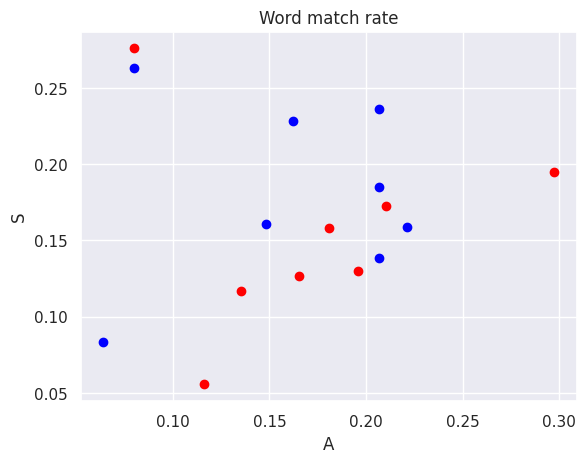

In [7]:
pop_youtube = youtube_popularity[:center]
unpop_youtube = youtube_popularity[center:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(pop_youtube["類似度_A"], pop_youtube["類似度_S"], c='blue')
ax.scatter(unpop_youtube["類似度_A"], unpop_youtube["類似度_S"], c='red')
ax.set_title("Word match rate")
ax.set_xlabel('A')
ax.set_ylabel('S')
fig.show()

# Spotifyにおける一致率の散布図

/tmp/ipykernel_73761/1019242828.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


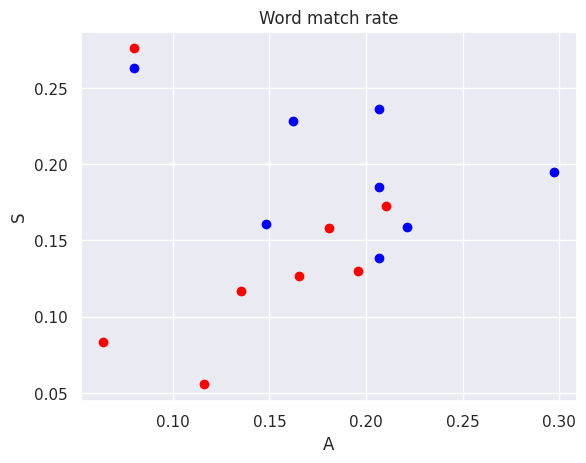

In [8]:
pop_spotify = spotify_popularity[:center]
unpop_spotify = spotify_popularity[center:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(pop_spotify["類似度_A"], pop_spotify["類似度_S"], c='blue')
ax.scatter(unpop_spotify["類似度_A"], unpop_spotify["類似度_S"], c='red')
ax.set_title("Word match rate")
ax.set_xlabel('A')
ax.set_ylabel('S')
fig.show()

# Aメロとサビの一致率の差の計算

In [9]:
pop_youtube_distance = np.abs(pop_youtube["類似度_S"] - pop_youtube["類似度_A"]) / np.sqrt(2)
unpop_youtube_distance = np.abs(unpop_youtube["類似度_S"] - unpop_youtube["類似度_A"]) / np.sqrt(2)

pop_spotify_distance = np.abs(pop_spotify["類似度_S"] - pop_spotify["類似度_A"]) / np.sqrt(2)
unpop_spotify_distance = np.abs(unpop_spotify["類似度_S"] - unpop_spotify["類似度_A"]) / np.sqrt(2)

# Youtubeにおける一致率の差のヴァイオリンプロットと箱ひげ図

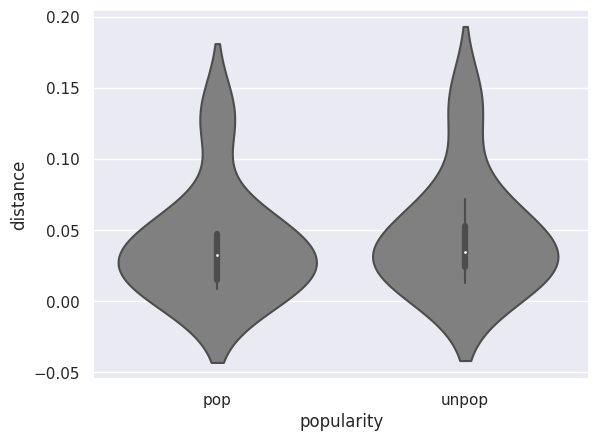

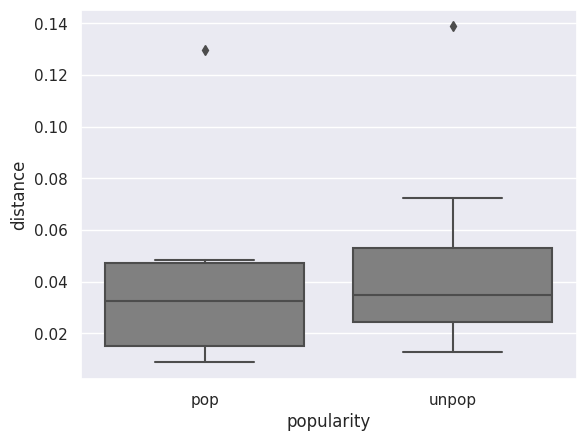

In [10]:
popularity = ["pop"] * len(pop_youtube_distance)
popularity.extend(["unpop"] * len(unpop_youtube_distance))

df_youtube_pop = pd.DataFrame({
    "popularity": ["pop"] * len(pop_youtube_distance),
    "distance": pop_youtube_distance,
})
df_youtube_unpop = pd.DataFrame({
    "popularity": ["unpop"] * len(unpop_youtube_distance),
    "distance": unpop_youtube_distance,
})
df_youtube = pd.concat([df_youtube_pop, df_youtube_unpop])

sns.violinplot(data=df_youtube, x="popularity", y="distance", color="gray")
plt.show()
sns.boxplot(data=df_youtube, x="popularity", y="distance", color='gray')
plt.show()

# Spotifyにおける一致率の差のヴァイオリンプロットと箱ひげ図

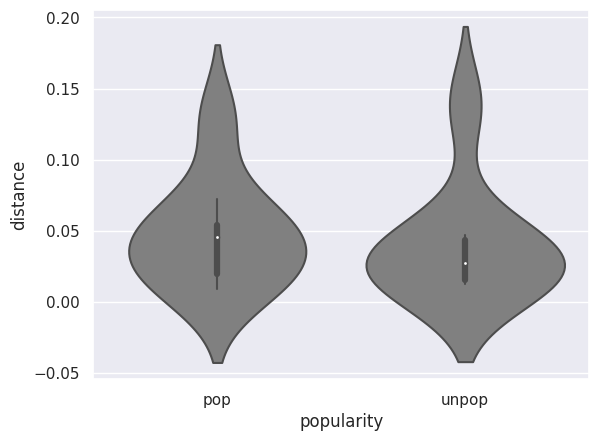

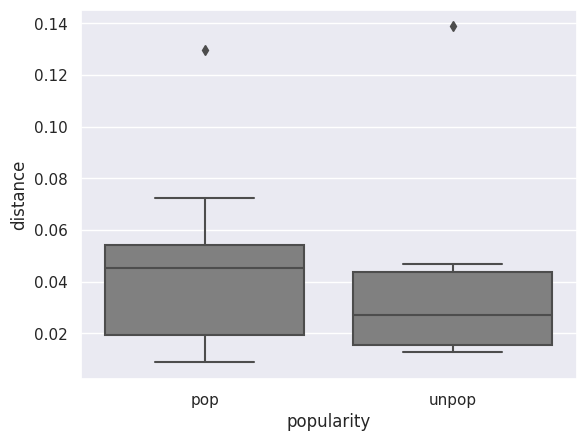

In [11]:
popularity = ["pop"] * len(pop_spotify_distance)
popularity.extend(["unpop"] * len(unpop_spotify_distance))

df_spotify_pop = pd.DataFrame({
    "popularity": ["pop"] * len(pop_spotify_distance),
    "distance": pop_spotify_distance,
})
df_spotify_unpop = pd.DataFrame({
    "popularity": ["unpop"] * len(unpop_spotify_distance),
    "distance": unpop_spotify_distance,
})
df_spotify = pd.concat([df_spotify_pop, df_spotify_unpop])

sns.violinplot(data=df_spotify, x="popularity", y="distance", color="gray")
plt.show()
sns.boxplot(data=df_spotify, x="popularity", y="distance", color='gray')
plt.show()